# Plant Pathology 2020 - FGVC7

# Data Loading and Cleaning

In [181]:
from fastai.vision import *
from fastai.callbacks import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

Data are already downloaded and stored in the `./data` directory.

In [2]:
data_root = Path("data")

In [3]:
data = pd.read_csv(data_root/"train.csv")
test = pd.read_csv(data_root/"test.csv")

In [194]:
data.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


It will be easier if we have our categorical data as a single feature instead of a one-hot encoded one.

We will create a new `'class'` feature and store the classes there. Drop the one-hot encoded methods.

In [4]:
healthy, mult, rust, scab = "healthy", "multiple_diseases", "rust", "scab"

In [5]:
items_arr = [healthy, mult, rust, scab]
for item in items_arr:
    data.loc[data[item] == 1, "class"] = item

In [6]:
data.drop(items_arr, axis=1, inplace=True)

# Useful Functions

Get training dataset with a specific size, transforms and batch size.

In [8]:
def get_train(tfms, size, bs):
    return (ImageList.from_df(data, data_root/"images", suffix=".jpg")
       .split_by_rand_pct(0.2, seed=2)
       .label_from_df("class")
       .add_test(test_data)
       .transform(tfms, size=size)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

Automatically train a model with different combinations of functions

# Modeling

Let's first work with the default transforms.

In [14]:
train = (ImageList.from_df(data, data_root/"images", suffix=".jpg")
       .split_by_rand_pct(0.2, seed=2) # 20% validation set
       .label_from_df("class") # label from "class" column of DataFrame
       .transform(get_transforms(), size=224) # default transforms, size of images = 224
       .databunch(bs=32) # batch size = 32, we can handle it
       .normalize(imagenet_stats)) # normalize dataset with the imagenet stats

In [15]:
test_data = ImageList.from_df(test, data_root/"images", suffix=".jpg") # do the same for the test dataset

We will use the `resnet152` model. The only reason I choose this other than `resnet50` or `resnet34` is that **it's a bigger number so it must be better amirite?**

In [286]:
learner = cnn_learner(train, models.resnet152, metrics=[accuracy, error_rate])

## Frozen learning rate experiments

Let's perform some experiments on the data with different learning rates, weight decays and momentums.

In [56]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


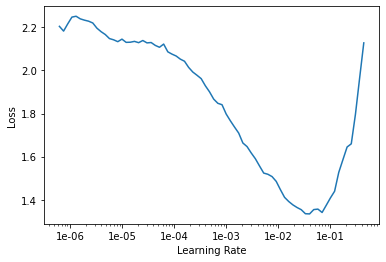

In [57]:
learner.recorder.plot()

The best learning rate seems to be `2e-3` but we'll try 10x more/less and 2x more/less just to be sure.

In [224]:
lr = 1e-3

In [229]:
lr = 2e-3

In [234]:
lr = 3e-3

In [238]:
lr = 2e-2

In [122]:
lr = 2e-4

In [247]:
lr = 2e-2 / 2

So what I do is change the learning rate according to the above blocks and execute `learn.fit_one_cycle` for each one using different combinations of momentums and weight decays as I see fit. Optimally, I could have done this with a for loop that iters through all the possible combinations and finds the best error rate.

Below are the best 3 outputs I got using the above methods. It seems that a learning rate of `1e-2` along with `moms=(0.8,0.7)` produces the best results without overfitting (see train_loss vs validation_loss).

In [287]:
lr = 2e-2
learner.fit_one_cycle(4, lr/2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.003430,1.976647,0.651099,0.348901,00:39
1,0.716265,0.650519,0.791209,0.208791,00:38
2,0.475497,0.303710,0.903846,0.096154,00:39
3,0.349247,0.232928,0.945055,0.054945,00:39


In [288]:
learner.save('resnet152-best3')

In [165]:
lr=2e-2
learner.fit_one_cycle(4, lr/2, moms=(0.8, 0.7), wd=1e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.906917,1.404710,0.741758,0.258242,00:40
1,0.645778,0.378282,0.879121,0.120879,00:40
2,0.473436,0.286530,0.909341,0.090659,00:41
3,0.314794,0.232664,0.934066,0.065934,00:40


In [167]:
learner.fit_one_cycle(1, lr/2, moms=(0.8, 0.7), wd=1e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.452670,0.194426,0.961538,0.038462,00:40


The above is my **BEST SCORE**. That's pretty impresive, especially since I haven't unfreezed yet, and I think I was mostly lucky. However, as shown below, I can consistently get `~0.04`ish after unfreezing. 

In [168]:
learner.save('resnet152-best')

In [284]:
lr=2e-2
learner.fit_one_cycle(6, lr/2, moms=(0.8, 0.7), wd=1e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.877585,1.988076,0.659341,0.340659,00:38
1,0.747775,0.539531,0.881868,0.118132,00:38
2,0.583910,0.522680,0.890110,0.109890,00:39
3,0.431655,0.442135,0.903846,0.096154,00:39
4,0.322531,0.270734,0.925824,0.074176,00:39
5,0.221242,0.228665,0.936813,0.063187,00:39


In [285]:
learner.save('resnet152-best2')

Below are the results of the various combinations of learning rates, weight decays and momentums I tried.

Just learning rates:

- lr = 1e-3 -> error_rate = 0.098 (5 cycles)
- lr = 2e-3 -> error_rate = 0.052 (5 cycles)
- lr = 3e-3 -> error_rate = 0.06 (4 cycles)
- lr = 2e-2 -> error_rate = 0.087 (4 cycles)
- lr = 2e-4 -> error_rate = 0.074 (8 cycles)

With momentums: `moms=(0.8,0.7)`

- lr = 1e-3 -> error_rate = 0.071 (3 cycles)
- lr = 2e-3 -> error_rate = 0.071 (5 cycles)
- lr = 3e-3 -> error_rate = 0.063 (4 cycles)
- lr = 1e-2 -> error_rate = 0.049451 (6 cycles)
- lr = 2e-2 -> error_rate = 0.065 (6 cycles)
- lr = 2e-4 -> error_rate = 0.087 (10 cycles)

With some weight decay `wd=1e-1`.

- lr = 1e-3 -> error_rate = 0.063187 (5 cycles)
- lr = 2e-3 -> error_rate = 0.074176 (5 cycles)
- lr = 3e-3 -> error_rate = 0.065934 (4 cycles)
- lr = 2e-2 -> error_rate = 0.074176 (4 cycles)
- lr = 1e-2 -> error_rate = 0.071429 (4 cycles)

With weights and momentums `wd=1e-3`, `moms=(0.8, 0.7)`.

- lr = 1e-3 -> error_rate 0.076923 (3 cycles)
- lr = 2e-3 -> error_rate 0.060440 (4 cycles)
- lr = 3e-3 -> error_rate 0.057692 (4 cycles)
- lr = 1e-2 -> error_rate 0.038462 (6 cycles)
- lr = 2e-2 -> error_rate 0.060440 (4 cycles)

With weights and momentums `wd=1e-2`, `moms=(0.8,0.7)`.

- lr = 3e-3 -> error_rate 0.054945 (5 cycles)
- lr = 2e-3 -> error_rate 0.060440 (5 cycles)
- lr = 1e-2 -> error_rate 0.052198 (6 cycles)

So it's proven that the best learning rate is probably 1e-2 with some combination of momentums and/or weight decay.

In [ ]:
best_lr = 2e-2/2
best_mom = (0.8, 0.7)
best_wd = 1e-3

# Unfreezing Experiments

Let's go on to unfreezing the model using our best estimators from before.

In [350]:
learner = cnn_learner(train, models.resnet152, metrics=[accuracy, error_rate])

In [294]:
model = 'resnet152-best'

In [306]:
model = 'resnet152-best2'

In [351]:
model = 'resnet152-best3'

In [352]:
learner.load(model);

The process I follow:

1. Create the learner
2. Select a model by executing the code block
3. Find the best learning rate and train some more.
4. Save the best estimators.

In [353]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


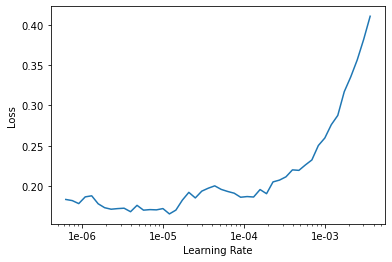

In [318]:
learner.lr_find()
learner.recorder.plot();

Below are my two best estimators. We see that I didn't get close to the `0.38` error rate I got before.

In [343]:
end = 2e-6
start = 1e-5

In [338]:
learner.fit_one_cycle(5, max_lr=slice(start, end), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.158214,0.231174,0.931319,0.068681,00:49
1,0.173532,0.204266,0.934066,0.065934,00:49
2,0.166517,0.207318,0.936813,0.063187,00:49
3,0.168916,0.191211,0.953297,0.046703,00:49
4,0.150303,0.192776,0.950549,0.049451,00:49


In [355]:
learner.save('resnet152-best-frozen2')

In [310]:
learner.fit_one_cycle(6, max_lr=slice(start, end), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.164616,0.208171,0.936813,0.063187,00:50
1,0.153331,0.204779,0.936813,0.063187,00:48
2,0.154019,0.196301,0.942308,0.057692,00:49
3,0.121548,0.193325,0.945055,0.054945,00:49
4,0.111435,0.183859,0.950549,0.049451,00:48
5,0.118031,0.185513,0.953297,0.046703,00:49


In [312]:
learner.save('resnet152-best-unfrozen')

## Working with transformations

Let's follow a similar approach but transforming the data first.

In [356]:
ds_tfms = get_transforms(
    do_flip=True,
    flip_vert=True,
    max_rotate=90.0,
    max_zoom=1.5,
    max_lighting=0.4,
    max_warp=0.4,
    p_affine=0.75,
    p_lighting=0.75
)

In [357]:
train = (ImageList.from_df(data, data_root/"images", suffix=".jpg")
       .split_by_rand_pct(0.2, seed=2)
       .label_from_df("class")
       .transform(ds_tfms, size=224)
       .databunch(bs=32)
       .normalize(imagenet_stats))

In [375]:
learner = cnn_learner(train, models.resnet152, metrics=[accuracy, error_rate])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


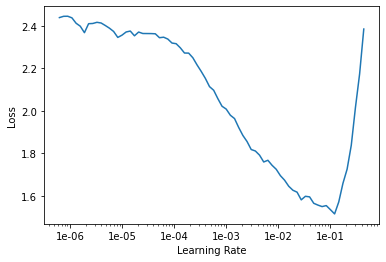

In [365]:
learner.lr_find()
learner.recorder.plot()

As expected we get a very similar plot as before.

Go through our best parameters and see if we get improved results.

In [376]:
lr = (2e-2)/2

In [377]:
learner.fit_one_cycle(8, lr, moms=(0.8, 0.7), wd=1e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.979796,1.576314,0.728022,0.271978,00:39
1,0.789235,2.161997,0.417582,0.582418,00:38
2,0.662587,0.515391,0.859890,0.140110,00:39
3,0.558325,0.442891,0.876374,0.123626,00:39
4,0.465942,0.231380,0.939560,0.060440,00:38
5,0.371222,0.207462,0.934066,0.065934,00:39
6,0.309352,0.182545,0.945055,0.054945,00:39
7,0.272037,0.170048,0.939560,0.060440,00:39


In [378]:
learner.save('first')

That's far from our best, but good nonetheless. Let's unfreeze to the second layer. Our validation loss is more than our training loss, so we can still perform some training without overfitting.

In [394]:
learner = cnn_learner(train, models.resnet152, metrics=[accuracy, error_rate])
learner.load('first');

Freeze to the second layer and find new learning rate.

In [395]:
learner.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


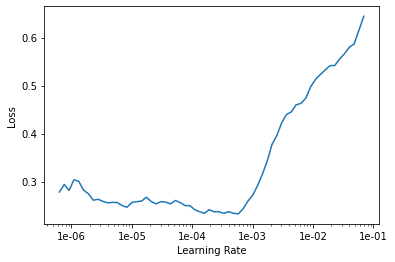

In [384]:
learner.lr_find()
learner.recorder.plot();

In [396]:
learner.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.291081,0.260282,0.923077,0.076923,00:51


In [397]:
learner.save('second')

Error rate didn't improve but let's continue.

In [398]:
learner.freeze_to(-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


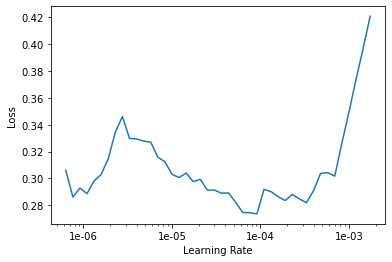

In [399]:
learner.lr_find()
learner.recorder.plot();

In [400]:
learner.fit_one_cycle(1, 5e-5)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.283706,0.204962,0.934066,0.065934,00:53


In [401]:
learner.save('third')

It improved, but no better than our initial training.

In [402]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


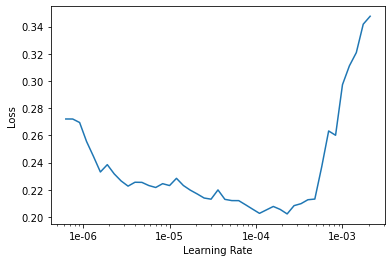

In [403]:
learner.lr_find()
learner.recorder.plot()

In [404]:
learner.fit_one_cycle(3, slice(2e-5, 2e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.226840,0.213098,0.942308,0.057692,00:51
1,0.273444,0.203417,0.950549,0.049451,00:53
2,0.251466,0.161104,0.953297,0.046703,00:53


In [406]:
learner.fit_one_cycle(1, slice(2e-5, 2e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.222595,0.172254,0.958791,0.041209,00:53


In [407]:
learner.save('resnet152-tfms-unfrozen')

That's a pretty good result (0.041209).

Let's try only with momentums.

In [421]:
learner = cnn_learner(train, models.resnet152, metrics=[accuracy, error_rate])

In [422]:
lr = 2e-2/2

In [423]:
learner.fit_one_cycle(6, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.048660,1.582624,0.678571,0.321429,00:46
1,0.854030,0.682082,0.835165,0.164835,00:47
2,0.687261,0.420635,0.895604,0.104396,00:46
3,0.563484,0.272304,0.920330,0.079670,00:47
4,0.430940,0.208707,0.939560,0.060440,00:47
5,0.335256,0.192344,0.942308,0.057692,00:47


In [424]:
learner.save('first')

Better than the model with weight decay.

In [448]:
learner.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


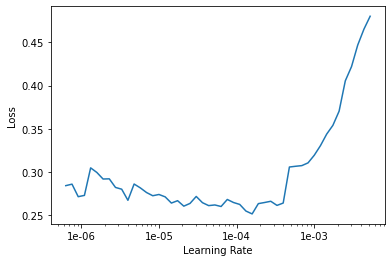

In [432]:
learner.lr_find()
learner.recorder.plot()

In [449]:
learner.fit_one_cycle(1, slice(4e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.346400,0.233663,0.931319,0.068681,00:51


In [435]:
learner.save('second')

In [438]:
learner = cnn_learner(train, models.resnet152, metrics=[accuracy, error_rate])
learner.load('second');

In [450]:
learner.freeze_to(-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


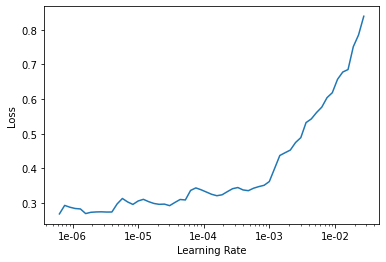

In [451]:
learner.lr_find()
learner.recorder.plot()

In [453]:
learner.fit_one_cycle(1, slice(4e-6), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.289564,0.216803,0.931319,0.068681,00:54


In [443]:
learner.save('third')

No improvement at all.

In [454]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


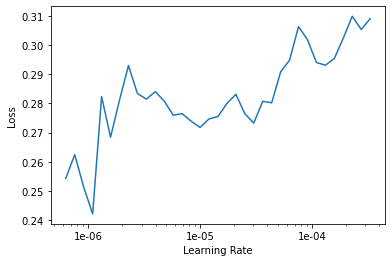

In [455]:
learner.lr_find()
learner.recorder.plot()

In [456]:
learner.fit_one_cycle(3, slice(3e-6, 2e-5), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.256800,0.200598,0.934066,0.065934,00:54
1,0.282173,0.193948,0.942308,0.057692,00:53
2,0.261942,0.200244,0.939560,0.060440,00:54


Nothing good comes out of this model.

# Re-evaluating and trying some models again using lessons learned.

So it seems the best learning rate is `1e-2` with some momentums or something around that. Let's focus on that here.

In [11]:
train = (ImageList.from_df(data, data_root/"images", suffix=".jpg")
       .split_by_rand_pct(0.2, seed=2) # 20% validation set
       .label_from_df("class") # label from "class" column of DataFrame
       .transform(get_transforms(), size=224) # default transforms, size of images = 224
       .databunch(bs=32) # batch size = 32, we can handle it
       .normalize(imagenet_stats)) # normalize dataset with the imagenet stats

In [12]:
ds_tfms = get_transforms(
    do_flip=True,
    flip_vert=True,
    max_rotate=90.0,
    max_zoom=1.5,
    max_lighting=0.4,
    max_warp=0.4,
    p_affine=0.75,
    p_lighting=0.75
)
train_tfms = (ImageList.from_df(data, data_root/"images", suffix=".jpg")
       .split_by_rand_pct(0.2, seed=2) # 20% validation set
       .label_from_df("class") # label from "class" column of DataFrame
       .transform(ds_tfms, size=224) # default transforms, size of images = 224
       .databunch(bs=32) # batch size = 32, we can handle it
       .normalize(imagenet_stats)) # normalize dataset with the imagenet stats

## resnet-34

In [30]:
learner = cnn_learner(train, models.resnet34, metrics=[error_rate])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


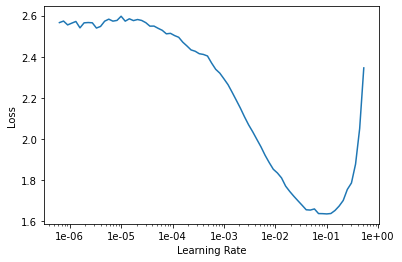

In [10]:
learner.lr_find()
learner.recorder.plot();

As expected we get a similar learning rate plot, since we haven't unfrozen the previous layers at all. So 1e-2 and around it will probably work great.

model go brrrrr

In [12]:
learner.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,error_rate,time
0,0.989368,0.711288,0.164835,00:44
1,0.760632,0.428963,0.131868,00:43
2,0.524153,0.343335,0.087912,00:43
3,0.392110,0.292852,0.079670,00:43
4,0.299495,0.270462,0.076923,00:43


We don't get very very good results, but let's move on to unfreezing.

In [13]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


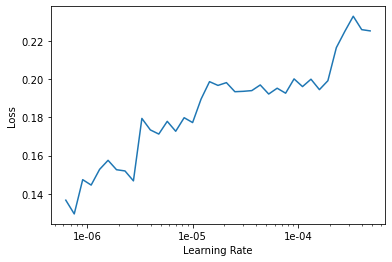

In [14]:
learner.lr_find()
learner.recorder.plot()

In [15]:
learner.fit_one_cycle(4, slice(2e-6, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.291082,0.262799,0.079670,00:44
1,0.238815,0.246392,0.085165,00:44
2,0.182711,0.223741,0.068681,00:44
3,0.141871,0.247906,0.076923,00:44


This doesn't work very well, we see that the error_rate fluctuates meaning that we haven't chosen good learning rates. Let's move on since the frozen results were not great either.

I just have a **fabulous** idea. Maybe I can try a much bigger learning rate than 1e-2, since the minimum on lr finder is around 8e-2. Let's see how that goes.

In [17]:
learner.fit_one_cycle(5, 3e-2)

epoch,train_loss,valid_loss,error_rate,time
0,0.940455,3.683046,0.453297,00:42
1,0.907173,1.212656,0.217033,00:42
2,0.748266,0.625615,0.115385,00:43
3,0.558600,0.312276,0.071429,00:42
4,0.402444,0.274198,0.068681,00:42


We get a much better result than 1e-3. That's promising!

In [18]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


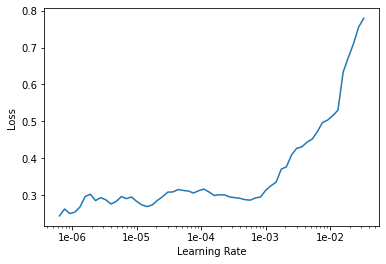

In [19]:
learner.lr_find()
learner.recorder.plot();

In [20]:
learner.fit_one_cycle(4, slice(8e-7, 2e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.289243,0.267558,0.071429,00:43
1,0.250326,0.269471,0.068681,00:43
2,0.259110,0.252150,0.060440,00:43
3,0.265617,0.265248,0.068681,00:43


Meh. Can't get below the 0.06 mark. But `3e-2` is very promising! Maybe try training for less epochs or with some momentums/weight decay??

In [22]:
learner.fit_one_cycle(3, 3e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,error_rate,time
0,1.192622,2.546404,0.401099,00:40
1,0.992017,0.598346,0.167582,00:40
2,0.629067,0.268250,0.065934,00:39


With just 3 cycles we get a better performance than before! Training loss is much higher than validation loss also.

In [26]:
learner.save('frozen')

In [32]:
learner.load('frozen');

In [33]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


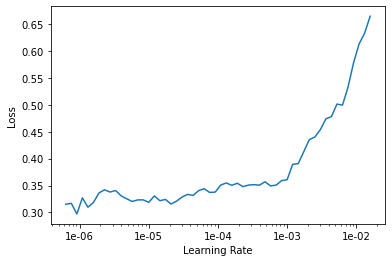

In [25]:
learner.lr_find()
learner.recorder.plot()

Hm. We get a pretty similar curve as before. But the previous values didn't help that much so let's try something different. Let's try a very small learning rate that sits near the global optima.

In [27]:
learner.fit_one_cycle(3, 7e-7, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,error_rate,time
0,0.315339,0.274194,0.071429,00:40
1,0.337208,0.271969,0.068681,00:40
2,0.352058,0.261509,0.063187,00:40


It moves very slowly but it's improving so let's train some more maybe. Going to massage a chicken brb.

In [28]:
learner.fit_one_cycle(3, 7e-7, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,error_rate,time
0,0.346821,0.276714,0.074176,00:39
1,0.349336,0.266313,0.068681,00:40
2,0.340417,0.270872,0.063187,00:40


Hmm, chicken is baking model ain't working. But training loss is much higher. Let's try with a sliced learning rate that goes somewhat up.

In [34]:
learner.fit_one_cycle(3, slice(7e-7, 2e-5), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,error_rate,time
0,0.335048,0.272496,0.063187,00:40
1,0.339916,0.270054,0.060440,00:40
2,0.335573,0.264210,0.065934,00:41


Not that great either. Let's move on, but keep lr=3e-2.

## resnet50

In [76]:
learner = cnn_learner(train, models.resnet50, metrics=[error_rate])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


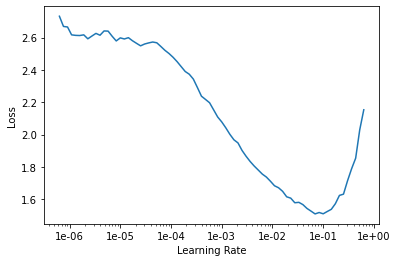

In [14]:
learner.lr_find()
learner.recorder.plot();

Again 3e-2 seems good.

In [21]:
learner.fit_one_cycle(3, 3e-2)

epoch,train_loss,valid_loss,error_rate,time
0,1.099616,4.534535,0.370879,00:42
1,1.015604,0.384870,0.090659,00:43
2,0.665000,0.279896,0.071429,00:42


Hmm very good performance. Better than resnet34 with the same parameters.

In [22]:
learner.save('simple')

In [36]:
learner.load('simple');

In [32]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


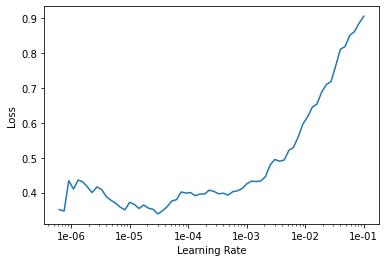

In [28]:
learner.lr_find()
learner.recorder.plot();

In [29]:
learner.fit_one_cycle(3, slice(4e-5, 3e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.444184,0.756736,0.162088,00:40
1,0.412111,0.303470,0.076923,00:40
2,0.368096,0.274398,0.065934,00:40


Let's try with momentums.

In [41]:
learner.fit_one_cycle(4, 3e-2, moms=(0.7, 0.6))

epoch,train_loss,valid_loss,error_rate,time
0,1.002294,2.773520,0.351648,00:40
1,1.005390,1.569060,0.368132,00:40
2,0.658157,0.325509,0.096154,00:40
3,0.393352,0.260090,0.068681,00:40


In [42]:
learner.save('moms')

In [49]:
learner.load('moms');

In [50]:
learner.unfreeze()

In [51]:
learner.fit_one_cycle(4, slice(1e-2/(2.6**4), 1e-2), moms=(0.7, 0.6))

epoch,train_loss,valid_loss,error_rate,time
0,0.486473,7.256037,0.461538,00:41
1,0.472289,0.483471,0.104396,00:41
2,0.385717,0.314102,0.082418,00:42
3,0.289169,0.270905,0.071429,00:42


let's try with some weight decay

In [59]:
learner.fit_one_cycle(6, 3e-2, moms=(0.8, 0.7), wd=1e-1)

epoch,train_loss,valid_loss,error_rate,time
0,0.841342,1.695810,0.299451,00:41
1,0.924600,0.797508,0.129121,00:41
2,0.626217,0.384470,0.109890,00:41
3,0.460929,0.663165,0.170330,00:40
4,0.334725,0.260621,0.082418,00:41
5,0.287969,0.240595,0.074176,00:41


In [60]:
learner.save('wd')

In [66]:
learner.load('wd');

In [67]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


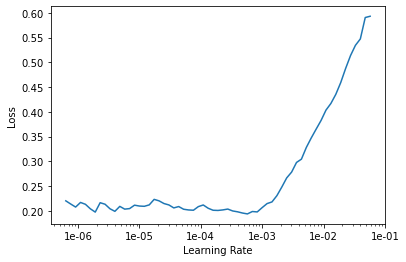

In [62]:
learner.lr_find()
learner.recorder.plot()

In [68]:
learner.fit_one_cycle(6, slice(3e-6, 3e-4), moms=(0.8, 0.7), wd=1e-1)

epoch,train_loss,valid_loss,error_rate,time
0,0.200779,0.215841,0.071429,00:43
1,0.219258,0.224727,0.076923,00:43
2,0.195984,0.203422,0.076923,00:43
3,0.187120,0.208971,0.068681,00:43
4,0.161074,0.205465,0.074176,00:43
5,0.157419,0.209824,0.082418,00:43


let's try weight decay = 1e-3 which was our best result before.

In [70]:
learner.fit_one_cycle(5, 3e-2, moms=(0.8, 0.7), wd=1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.989403,2.989120,0.475275,00:42
1,1.005236,0.987798,0.137363,00:41
2,0.716771,0.348797,0.096154,00:42
3,0.497204,0.293070,0.071429,00:42
4,0.343034,0.252034,0.065934,00:42


In [71]:
learner.save('wow')

In [77]:
learner.load('wow');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


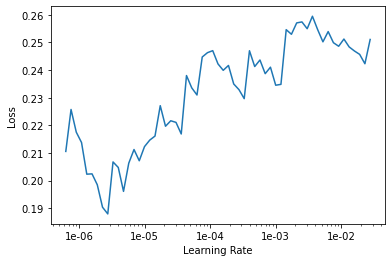

In [78]:
learner.lr_find()
learner.recorder.plot()

In [ ]:
learner.fit_one_cycle(3, 2e-6, moms=(0.8, 0.7), wd=1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.199373,0.239417,0.063187,00:41


### resnet-152

In [22]:
learner = cnn_learner(train, models.resnet152, metrics=[error_rate])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


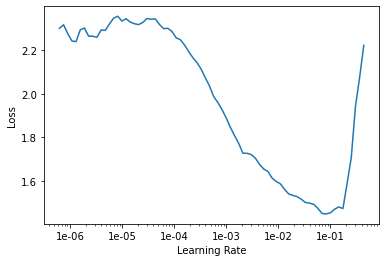

In [10]:
learner.lr_find()
learner.recorder.plot()

In [11]:
learner.fit_one_cycle(4, 5e-2, wd=1e-1)

epoch,train_loss,valid_loss,error_rate,time
0,1.171833,46.017910,0.623626,00:52
1,1.183415,0.574779,0.192308,00:51
2,0.730312,0.408567,0.137363,00:51
3,0.508988,0.330455,0.104396,00:51


A large learning rate does not work. But 3e-2 isn't on a steep hill.

Let's try a smaller learning rate on a steeper hill.

In [13]:
learner.fit_one_cycle(5, 1e-3, wd=1e-1)

epoch,train_loss,valid_loss,error_rate,time
0,1.059350,0.518834,0.140110,00:50
1,0.715513,0.333579,0.087912,00:50
2,0.496763,0.256854,0.071429,00:49
3,0.355939,0.244917,0.087912,00:49
4,0.269945,0.227236,0.074176,00:50


Hm not that great also. We've actually found that for resnet-152 the best learning rate is 1e-2. Let's try that out again, with some weight decay.

In [15]:
learner.fit_one_cycle(5, 1e-2, wd=1e-1)

epoch,train_loss,valid_loss,error_rate,time
0,0.870525,1.479026,0.271978,00:50
1,0.630050,0.572932,0.148352,00:47
2,0.483455,0.362794,0.107143,00:46
3,0.353511,0.237038,0.071429,00:46
4,0.276358,0.197169,0.076923,00:46


In [17]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


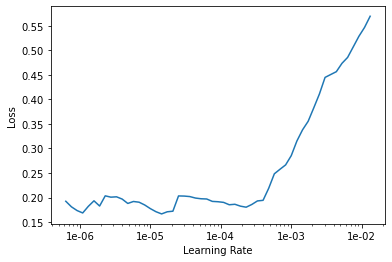

In [19]:
learner.lr_find()
learner.recorder.plot()

In [20]:
learner.fit_one_cycle(3, slice(7e-7, 2e-5), wd=1e-1)

epoch,train_loss,valid_loss,error_rate,time
0,0.160294,0.181015,0.060440,00:49
1,0.184939,0.173682,0.052198,00:50
2,0.156928,0.169301,0.052198,00:50


Hmmm pretty good. Let's save this model.

In [21]:
learner.save('1e-2-unfrozen')

Let's try the same thing with pct_start.

In [23]:
gc.collect()
learn = cnn_learner(train, models.resnet152, metrics=[error_rate])

In [24]:
learner.fit_one_cycle(4, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,1.092978,0.745386,0.173077,00:48
1,0.676885,0.508512,0.126374,00:46
2,0.566259,0.547431,0.131868,00:46
3,0.437981,0.280410,0.082418,00:47


In [25]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


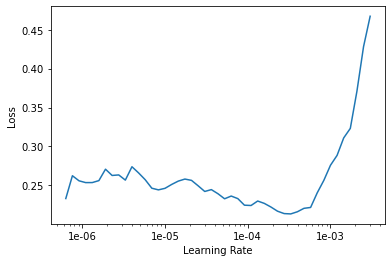

In [26]:
learner.lr_find()
learner.recorder.plot()

In [27]:
learner.fit_one_cycle(3, slice(1e-6, 1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.206806,0.270610,0.076923,00:51
1,0.184768,0.273541,0.079670,00:51
2,0.194853,0.270315,0.079670,00:52


In [44]:
train_big = (ImageList.from_df(data, data_root/"images", suffix=".jpg")
       .split_by_rand_pct(0.2, seed=2) # 20% validation set
       .label_from_df("class") # label from "class" column of DataFrame
       .transform(get_transforms(), size=352) # default transforms, size of images = 224
       .databunch(bs=4) # batch size = 32, we can handle it
       .normalize(imagenet_stats)) # normalize dataset with the imagenet stats

In [13]:
train_med = (ImageList.from_df(data, data_root/"images", suffix=".jpg")
       .split_by_rand_pct(0.2, seed=2) # 20% validation set
       .label_from_df("class") # label from "class" column of DataFrame
       .transform(get_transforms(), size=288) # default transforms, size of images = 224
       .databunch(bs=16) # batch size = 32, we can handle it
       .normalize(imagenet_stats)) # normalize dataset with the imagenet stats

In [45]:
learner.data = train_med

In [46]:
learner.fit_one_cycle(2, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.882612,0.274578,0.085165,02:03
1,0.664630,0.183135,0.052198,02:02


That's very good. Let's try the same approach with some weight decay and a smaller pct_start.

In [74]:
learner = cnn_learner(train, models.resnet152, metrics=[error_rate])

In [49]:
learner.fit_one_cycle(4, 1e-2, wd=1e-2, pct_start=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,0.859316,0.598987,0.184066,00:46
1,0.626399,0.711438,0.123626,00:46
2,0.507973,0.354110,0.101648,00:45
3,0.338200,0.292524,0.071429,00:46


In [50]:
learner.unfreeze()

In [51]:
learner.fit_one_cycle(3, slice(1e-6, 1e-3), wd=1e-2, pct_start=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,0.197078,0.224359,0.060440,00:50
1,0.223461,0.286799,0.071429,00:51
2,0.182356,0.219882,0.054945,00:50


Very nice!!

In [52]:
learn.save('152-unfrozen-wd')

In [75]:
learn.load('152-unfrozen-wd');

In [76]:
learner.data = train_big

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


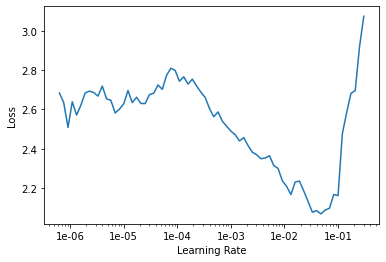

In [63]:
learner.lr_find()
learner.recorder.plot()

Oh shit we can have a very good learning rate. Let's train with lr=slice(1e-4, 3e-2) with some weight decay.

In [77]:
learner.fit_one_cycle(4, slice(1e-4, 8e-3), wd=1e-1)

epoch,train_loss,valid_loss,error_rate,time
0,1.234051,0.688595,0.192308,01:29
1,0.920127,0.527024,0.184066,01:29
2,0.586033,0.359786,0.118132,01:29
3,0.568597,0.282661,0.074176,01:29


In [78]:
learner.fit_one_cycle(2, slice(1e-4, 8e-3), wd=1e-1)

epoch,train_loss,valid_loss,error_rate,time
0,0.719409,0.366972,0.109890,01:27
1,0.549968,0.267490,0.068681,01:28


Ah that's okay let's keep it.

In [83]:
learner.save('wd-1e-1')

In [107]:
learner = cnn_learner(train, models.resnet152, metrics=[error_rate])

In [85]:
learner.fit_one_cycle(5, 1e-2, moms=(0.8, 0.7), pct_start=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,0.807293,0.722922,0.153846,00:46
1,0.632183,2.087923,0.329670,00:46
2,0.541396,0.392400,0.118132,00:46
3,0.405462,0.246599,0.068681,00:46
4,0.279395,0.161335,0.043956,00:47


Oh shit that's very very very good.

In [86]:
learner.save('beforefreeze')

(At that point I must have saved 1000 different models).

In [108]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


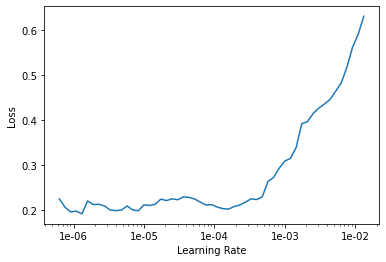

In [88]:
learner.lr_find()
learner.recorder.plot()

In [90]:
learner.fit_one_cycle(4, slice(1e-6, 1e-4), moms=(0.8, 0.7), pct_start=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,0.181878,0.157019,0.046703,00:52
1,0.182862,0.172012,0.046703,00:51
2,0.165108,0.151289,0.038462,00:53
3,0.144179,0.148632,0.046703,00:52


OK very very very good.

In [92]:
learner.save('afterfreeze')

In [109]:
learner.load('afterfreeze');

In [111]:
learner.data = train_med

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


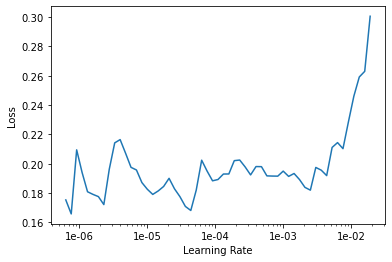

In [112]:
learner.lr_find()
learner.recorder.plot()

In [113]:
learner.fit_one_cycle(4, 3e-5, moms=(0.8, 0.7), pct_start=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,0.246451,0.144233,0.032967,00:55
1,0.217981,0.142151,0.041209,00:56
2,0.187635,0.142013,0.035714,00:56
3,0.202798,0.145652,0.035714,00:56


**NEW BEST SCORE** **YAYAYAYAYAYAYA**

Amazing!!! We got our best one yet 0.032 with just one cycle!!!

In [114]:
learner.save('bestbestbest')

In [22]:
train_med2 = (ImageList.from_df(data, data_root/"images", suffix=".jpg")
       .split_by_rand_pct(0.2, seed=2) # 20% validation set
       .label_from_df("class") # label from "class" column of DataFrame
       .transform(get_transforms(), size=304) # default transforms, size of images = 224
       .databunch(bs=16) # batch size = 32, we can handle it
       .normalize(imagenet_stats)) # normalize dataset with the imagenet stats

In [ ]:
learner = cnn_learner(train, models.resnet152, metrics=[error_rate])
learner.load('bestbestbest');

In [ ]:
learner.data = train_med2

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


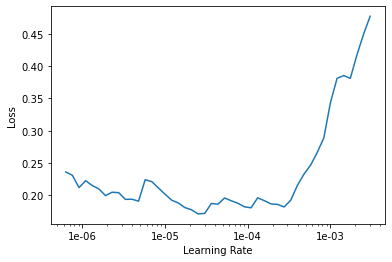

In [199]:
learner.lr_find()
learner.recorder.plot()

In [205]:
learner.fit_one_cycle(4, slice(1e-6, 1e-4), moms=(0.8, 0.7), pct_start=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,0.205832,0.153428,0.043956,01:16
1,0.228159,0.131815,0.038462,01:15
2,0.192381,0.145974,0.043956,01:15
3,0.149005,0.139525,0.032967,01:15


**EVEN BETTER SCORE**

In [ ]:
train = get_train(get_transforms(), 224, 32)
learner = cnn_learner(train, models.resnet152, metrics=[error_rate])
learner.load('afterfreeze');

In [214]:
learner.data = get_train(get_transforms(), 288, 32)

In [209]:
learner.fit_one_cycle(2, 3e-5, moms=(0.8, 0.7), pct_start=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,0.144996,0.144863,0.032967,00:59
1,0.144241,0.145246,0.032967,01:00


In [210]:
learner.save('bestofbest')

In [312]:
learner.load('bestofbest');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


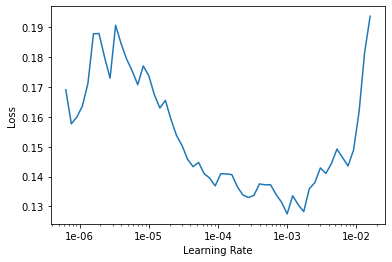

In [304]:
learner.lr_find()
learner.recorder.plot()

In [313]:
learner.fit_one_cycle(1, 2e-5 + 0.5 * 2e-5, moms=(0.8, 0.7), pct_start=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,0.139845,0.149084,0.032967,00:55


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


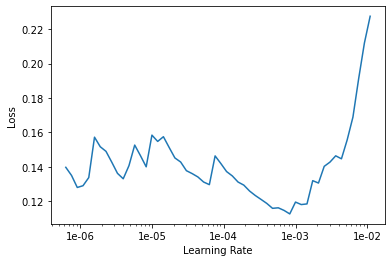

In [211]:
learner.lr_find()
learner.recorder.plot()

In [238]:
find_best_model(learner, 'bestofbest', 'secret', 2, [3e-5], [5e-3, 5e-2, 5e-1], [(0.8, 0.7), (0.9, 0.8)], [0.4, 0.5, 0.6])

epoch,train_loss,valid_loss,error_rate,time
0,0.141824,0.140259,0.041209,00:57
1,0.130509,0.139669,0.038462,00:58


epoch,train_loss,valid_loss,error_rate,time
0,0.180342,0.143986,0.035714,00:59
1,0.148893,0.140756,0.041209,01:00


epoch,train_loss,valid_loss,error_rate,time
0,0.150684,0.143650,0.041209,01:01
1,0.138979,0.149017,0.035714,01:00


epoch,train_loss,valid_loss,error_rate,time
0,0.131479,0.136806,0.041209,01:01
1,0.137348,0.147887,0.038462,01:00


epoch,train_loss,valid_loss,error_rate,time
0,0.140021,0.141719,0.030220,01:00
1,0.156024,0.144768,0.032967,01:00


epoch,train_loss,valid_loss,error_rate,time
0,0.142433,0.139956,0.043956,01:00
1,0.146389,0.139487,0.035714,01:00


epoch,train_loss,valid_loss,error_rate,time
0,0.123651,0.137296,0.038462,01:01
1,0.144476,0.142906,0.041209,01:00


epoch,train_loss,valid_loss,error_rate,time
0,0.133928,0.147945,0.035714,01:01
1,0.126667,0.140528,0.041209,01:00


epoch,train_loss,valid_loss,error_rate,time
0,0.155695,0.142005,0.032967,01:01
1,0.144200,0.143598,0.038462,01:00


epoch,train_loss,valid_loss,error_rate,time
0,0.133608,0.140145,0.038462,01:01
1,0.166178,0.142406,0.035714,01:00


epoch,train_loss,valid_loss,error_rate,time
0,0.170252,0.143244,0.035714,01:01
1,0.142284,0.141797,0.035714,01:00


epoch,train_loss,valid_loss,error_rate,time
0,0.159768,0.144624,0.041209,01:00
1,0.140531,0.142941,0.038462,01:00


epoch,train_loss,valid_loss,error_rate,time
0,0.154050,0.141066,0.032967,01:01
1,0.142055,0.136042,0.035714,01:00


epoch,train_loss,valid_loss,error_rate,time
0,0.150089,0.142591,0.030220,01:01
1,0.127964,0.138725,0.035714,01:00


epoch,train_loss,valid_loss,error_rate,time
0,0.153450,0.142002,0.041209,01:01
1,0.148466,0.143879,0.032967,01:01


epoch,train_loss,valid_loss,error_rate,time
0,0.131083,0.141805,0.038462,01:01
1,0.165162,0.139817,0.032967,01:01


epoch,train_loss,valid_loss,error_rate,time
0,0.157088,0.142453,0.038462,01:01
1,0.151125,0.142695,0.035714,01:01


epoch,train_loss,valid_loss,error_rate,time
0,0.152536,0.140081,0.038462,01:01
1,0.145566,0.145251,0.035714,01:01


(0.032967034727334976, [3e-05, 0.005, (0.9, 0.8), 0.5])

Many promising avenues here at positions 4(1), 10(2), 13(1), 14(2), 15(2). And a **new best score**: 0.03

In [291]:
train = get_train(get_transforms(), 288, 32)
learner = cnn_learner(train, models.resnet152, metrics=[error_rate])

In [131]:
learner.load('afterfreeze');

In [126]:
learner.validate()

[0.16160867, tensor(0.0440)]

In [132]:
learner.fit_one_cycle(4, 3e-5, wd=5e-3, moms=(0.8, 0.7), pct_start=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,0.154474,0.150128,0.041209,00:57
1,0.163377,0.140364,0.035714,00:56
2,0.143278,0.142377,0.035714,00:56
3,0.158263,0.145001,0.035714,00:56


In [ ]:
learner.load('idk');

In [185]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


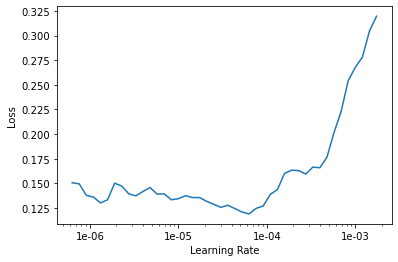

In [140]:
learner.lr_find()
learner.recorder.plot()

In [141]:
learner.fit_one_cycle(2, slice(1e-6, 5e-5), wd=5e-3, moms=(0.8, 0.7), pct_start=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,0.142808,0.139959,0.038462,01:14
1,0.141081,0.140633,0.038462,01:14


In [142]:
learner.fit_one_cycle(2, slice(1e-6, 5e-5), wd=5e-3, moms=(0.8, 0.7), pct_start=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,0.104844,0.127239,0.035714,01:14
1,0.118464,0.133676,0.035714,01:13


In [143]:
learner.fit_one_cycle(2, slice(1e-6, 5e-5), wd=5e-3, moms=(0.8, 0.7), pct_start=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,0.120123,0.134340,0.032967,01:14
1,0.105982,0.127337,0.032967,01:14


In [144]:
learner.save('bestofbestunfrozen')

In [190]:
learner.load('bestofbestunfrozen');

In [187]:
learner.fit_one_cycle(4, slice(1e-6, 6e-5), wd=5e-3, moms=(0.8, 0.7), pct_start=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,0.100653,0.126478,0.041209,01:14
1,0.097259,0.129485,0.030220,01:14
2,0.094471,0.131921,0.035714,01:15
3,0.082932,0.131957,0.032967,01:14


Better model found at epoch 0 with error_rate value: 0.041208792477846146.


In [191]:
learner.fit_one_cycle(2, slice(1e-6, 5e-5), wd=5e-3, moms=(0.8, 0.7), pct_start=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,0.109763,0.124698,0.032967,01:14
1,0.106044,0.121679,0.032967,01:14


In [192]:
learner.save('bestofbestunfrozen2')

In [ ]:
learner.load('bestofbestunfrozen2')

In [194]:
learner.fit_one_cycle(2, slice(1e-6, 5e-5), wd=5e-3, moms=(0.8, 0.7), pct_start=0.5,
                     callbacks=[SaveModelCallback(learner, every='improvement', monitor='error_rate', name='bestcallback')])

epoch,train_loss,valid_loss,error_rate,time
0,0.098916,0.117445,0.030220,01:14
1,0.094672,0.119720,0.030220,01:14


Better model found at epoch 0 with error_rate value: 0.030219780281186104.


In [195]:
learner.save('bestofbestunfrozen3')

In [204]:
learner.load('bestofbestunfrozen3');

In [206]:
learner.fit_one_cycle(2, slice(1e-6, 6e-6), wd=5e-3, moms=(0.8, 0.7), pct_start=0.5,
                     callbacks=[SaveModelCallback(learner, every='improvement', monitor='error_rate', name='bestcallback')])

epoch,train_loss,valid_loss,error_rate,time
0,0.093157,0.121228,0.032967,00:57
1,0.092291,0.113982,0.027473,00:56


Better model found at epoch 0 with error_rate value: 0.032967034727334976.


**YES YES YES YES** Broke the 0.2 MARK THAT'S THE GREAT!!

In [207]:
learner.save('amazingwow')

In [391]:
train = get_train(get_transforms(), 288, 32)
learner = cnn_learner(train, models.resnet152, metrics=[error_rate])

In [324]:
learner.load('amazingwow');

In [325]:
learner.unfreeze()

In [240]:
learner.fit_one_cycle(1, slice(1e-6, 2e-6), wd=5e-3, moms=(0.8, 0.7), pct_start=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,0.086585,0.116734,0.027473,01:14


In [241]:
learner.save('amazingwow2')

In [331]:
learner.load('amazingwow2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


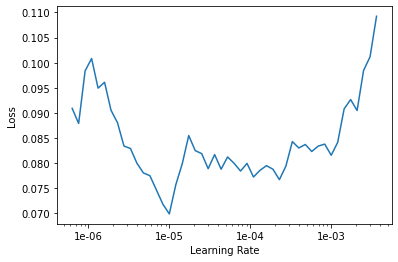

In [332]:
learner.lr_find()
learner.recorder.plot()

In [334]:
learner.fit_one_cycle(1, 8e-6, wd=0.2, moms=(0.8, 0.7), pct_start=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,0.077489,0.115810,0.027473,00:56


In [335]:
learner.save('now')

In [392]:
learner.load('now');

In [393]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


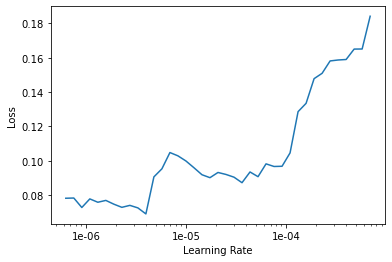

In [360]:
learner.lr_find()
learner.recorder.plot()

In [394]:
learner.fit_one_cycle(2, slice(1e-6, 4e-6), wd=5e-2, moms=(0.8, 0.7), pct_start=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,0.080049,0.123239,0.027473,01:14
1,0.079198,0.114475,0.027473,01:13


In [395]:
learner.fit_one_cycle(2, slice(2e-6, 4e-6), wd=5e-2, moms=(0.8, 0.7), pct_start=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,0.065745,0.116688,0.030220,01:13
1,0.071683,0.117533,0.027473,01:13


In [396]:
learner.fit_one_cycle(1, slice(2e-6, 4e-6), wd=5e-2, moms=(0.8, 0.7), pct_start=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,0.061720,0.118898,0.027473,01:13


In [ ]:
learner.fit_one_cycle(1, slice(2e-6, 4e-6), wd=5e-3, moms=(0.8, 0.7), pct_start=0.5)

epoch,train_loss,valid_loss,error_rate,time


In [372]:
learner.fit_one_cycle(2, slice(2e-6, 4e-6), wd=5e-3, moms=(0.8, 0.7), pct_start=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,0.067126,0.122750,0.032967,01:14
1,0.075441,0.122058,0.027473,01:13


In [361]:
learner.fit_one_cycle(3, slice(2e-6, 4e-6), wd=5e-3, moms=(0.8, 0.7), pct_start=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,0.089117,0.118814,0.030220,01:13
1,0.075385,0.116163,0.024725,01:13


KeyboardInterrupt: 

In [362]:
learner.validate()

[0.11616255, tensor(0.0247)]

**EVEN BETTER**

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


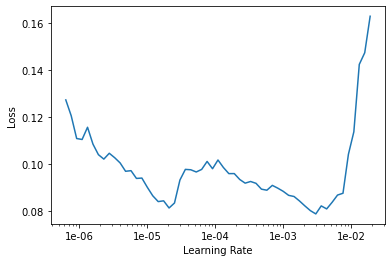

In [249]:
learner.lr_find()
learner.recorder.plot()

In [254]:
learner.fit_one_cycle(1, 2e-5, wd=5e-2, moms=(0.8, 0.7), pct_start=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,0.084134,0.116586,0.030220,00:54


In [255]:
learner.fit_one_cycle(1, 2e-5, wd=5e-2, moms=(0.8, 0.7), pct_start=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,0.089753,0.114536,0.030220,00:55


In [256]:
learner.fit_one_cycle(1, 2e-5, wd=5e-2, moms=(0.8, 0.7), pct_start=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,0.066914,0.115513,0.027473,00:55


In [257]:
learner.save('amazingwow3')

In [288]:
train = get_train(get_transforms(), 288, 32)
learner = cnn_learner(train, models.resnet152, metrics=[error_rate])

In [284]:
learner.load('amazingwow3');

In [280]:
find_best_model(learner, 'amazingwow3', 'amazingwow4', 2, [2e-5, 3e-5], [None, 1e-3], [(0.8, 0.7), (0.9, 0.8)], [0.5])

Trying  2e-05 None (0.8, 0.7) 0.5


epoch,train_loss,valid_loss,error_rate,time
0,0.087480,0.119228,0.030220,00:57
1,0.079626,0.117911,0.027473,00:56


Trying  2e-05 None (0.9, 0.8) 0.5


epoch,train_loss,valid_loss,error_rate,time
0,0.071437,0.116364,0.030220,00:57
1,0.087708,0.118170,0.032967,00:56


Trying  2e-05 0.001 (0.8, 0.7) 0.5


epoch,train_loss,valid_loss,error_rate,time
0,0.087080,0.116007,0.030220,00:56
1,0.092484,0.120742,0.030220,00:57


Trying  2e-05 0.001 (0.9, 0.8) 0.5


epoch,train_loss,valid_loss,error_rate,time
0,0.080792,0.118592,0.035714,00:57
1,0.069692,0.117106,0.027473,00:57


Trying  3e-05 None (0.8, 0.7) 0.5


epoch,train_loss,valid_loss,error_rate,time
0,0.086956,0.120836,0.030220,00:57
1,0.077260,0.113204,0.027473,00:57


Trying  3e-05 None (0.9, 0.8) 0.5


epoch,train_loss,valid_loss,error_rate,time
0,0.072480,0.115879,0.030220,00:57
1,0.101517,0.118445,0.030220,00:56


Trying  3e-05 0.001 (0.8, 0.7) 0.5


epoch,train_loss,valid_loss,error_rate,time
0,0.087979,0.118776,0.030220,00:57
1,0.081946,0.114780,0.030220,00:57


Trying  3e-05 0.001 (0.9, 0.8) 0.5


epoch,train_loss,valid_loss,error_rate,time
0,0.084283,0.115838,0.027473,00:57
1,0.078457,0.117827,0.032967,00:57


(0.02747252769768238, [2e-05, None, (0.8, 0.7), 0.5])

## A more formalized approach for different sizes

Let's try again with different sizes.

In [7]:
def get_train(tfms, size, bs):
    return (ImageList.from_df(data, data_root/"images", suffix=".jpg")
       .split_by_rand_pct(0.2, seed=2)
       .label_from_df("class")
       .add_test(test_data)
       .transform(tfms, size=size)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

In [74]:
inittrain = get_train(get_transforms(), 224, 32)

In [138]:
learner = cnn_learner(inittrain, models.resnet152, metrics=[error_rate])

In [79]:
learner.fit_one_cycle(5, 1e-2, moms=(0.8, 0.7), wd=1e-3, pct_start=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,0.813844,0.693380,0.107143,00:44
1,0.681517,0.507850,0.142857,00:45
2,0.498960,0.834017,0.148352,00:46
3,0.420212,0.217337,0.057692,00:45
4,0.291760,0.179305,0.046703,00:45


In [80]:
learner.save('first')

In [118]:
learner.load('first');

In [119]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


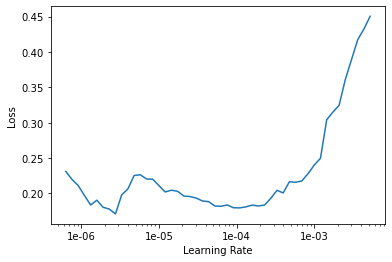

In [107]:
learner.lr_find()
learner.recorder.plot()

In [120]:
learner.fit_one_cycle(2, 2e-6, moms=(0.8, 0.7), wd=1e-3, pct_start=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,0.180996,0.181326,0.049451,00:48
1,0.191091,0.179898,0.052198,00:50


In [121]:
learner.save('second')

In [69]:
learner.load('second');

In [122]:
train_med = get_train(get_transforms(), 288, 32)

In [123]:
learner.data = train_med

In [124]:
learner.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


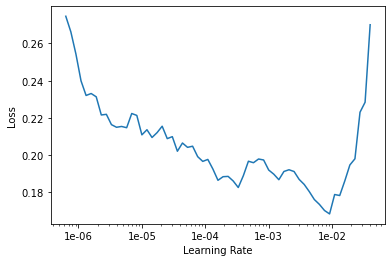

In [125]:
learner.lr_find()
learner.recorder.plot()

In [126]:
learner.fit_one_cycle(4, 6e-3, moms=(0.8, 0.7), wd=1e-3, pct_start=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,0.233987,0.382476,0.087912,00:57
1,0.369591,0.678492,0.184066,00:55
2,0.327799,0.415098,0.090659,00:54
3,0.261216,0.164718,0.046703,00:54


In [127]:
learner.save('third')

In [134]:
learner.load('third');

In [128]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


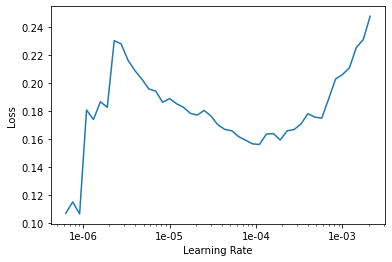

In [129]:
learner.lr_find()
learner.recorder.plot()

In [130]:
learner.fit_one_cycle(2, slice(1e-6, 1e-4), moms=(0.8, 0.7), wd=1e-3, pct_start=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,0.171201,0.151905,0.057692,01:10
1,0.174453,0.144801,0.043956,01:11


In [132]:
learner.save('fourth')

In [202]:
learner.load('fourth');

# Automation

Trying different parameters every time and then checking the results **SUCKS**. I want to be able to eat my chicken in peace!!

To resolve this issue (and my hunger) I'm gonna implement a method that takes a list of learning rates, weight decays, momentums, and whatever and tries all their possible combinations.

This will allow us to try different parameters in an effective manner, also making sure that we don't forget about a combination.

Moreover, we can just leave it running, and go read our favorite book (just got Bishop's book so I'm flexing rn).

First, we need to create a torch with our predicted variables. The only way I could find to do this in fastai is the following:

In [16]:
inittrain = get_train(get_transforms(), 224, 32)

In [17]:
mapping = {"healthy": 0, "multiple_diseases": 1, "rust": 2, "scab": 3} # define a mapping between classes and ints
ls = [mapping[str(x)] for x in list(inittrain.valid_ds.y)] # get the integer representations of the validation set
valid = torch.zeros(len(ls), len(list(mapping.keys()))) # create a Nx4 tensor of zeros to store our predictions
for i, x in enumerate(ls): # fill 1 to the valid class positions
    valid[i, x] = 1.

In [18]:
import itertools

def find_best_model(learner, input_model, output_model, cycles, lrs, wd, moms, pct_start):
    """
    learner      -> our learner object
    input_model  -> where are our previous params stored
    output_model -> where should we store our best params
    cycles       -> for how many cycles should we train
    lrs          -> list of learning rates to try
    wd           -> list of weight decays to try
    moms         -> list of momentums to try
    pct_start    -> list of percentages to try for rising/falling learning rate
    """
    prod = itertools.product(lrs, wd, moms, pct_start) # get the combinations
    minerr = float("inf") # these vars will store our minimum error rate and best params
    bestparams = None
    for l, w, m, p in prod:
        learner.load(input_model) # load params
        print("Trying ", l, w, m, p)
        learner.fit_one_cycle(cycles, max_lr=l, wd=w, moms=m, pct_start=p) # train
        err_rate = float(learner.validate()[1]) # get error rate of training
        if err_rate < minerr: # new best!
            minerr = err_rate
            bestparams = [l, w, m, p]
            learner.save(output_model)
    return minerr, bestparams

In [134]:
inittrain = get_train(get_transforms(), 224, 32)
learner = cnn_learner(inittrain, models.resnet152, metrics=[error_rate])
learner.save('zero')

In [135]:
find_best_model(learner, 'zero', 'first', 4, [1e-2, 2e-2, 3e-2], [1e-3, 1e-2], [(0.8, 0.7), (0.9, 0.8)], [0.4, 0.5, 0.6])

epoch,train_loss,valid_loss,error_rate,time
0,0.928329,0.663857,0.211538,00:44
1,0.679377,0.932712,0.217033,00:43
2,0.541820,0.289141,0.076923,00:44
3,0.354461,0.207928,0.074176,00:44


epoch,train_loss,valid_loss,error_rate,time
0,0.902578,1.964450,0.269231,00:45
1,0.678954,1.211191,0.387363,00:45
2,0.532761,0.245702,0.054945,00:45
3,0.343237,0.189244,0.068681,00:45


epoch,train_loss,valid_loss,error_rate,time
0,0.896739,1.877349,0.392857,00:45
1,0.657855,0.703441,0.206044,00:45
2,0.569218,0.637472,0.112637,00:45
3,0.396548,0.277475,0.063187,00:46


epoch,train_loss,valid_loss,error_rate,time
0,0.980861,1.144894,0.318681,00:47
1,0.685053,0.509521,0.151099,00:45
2,0.476167,0.326125,0.082418,00:46
3,0.330548,0.230200,0.057692,00:46


epoch,train_loss,valid_loss,error_rate,time
0,0.954285,2.483779,0.324176,00:46
1,0.674076,0.582121,0.148352,00:46
2,0.528337,0.396047,0.082418,00:46
3,0.371092,0.226314,0.060440,00:47


epoch,train_loss,valid_loss,error_rate,time
0,0.871940,0.580411,0.107143,00:46
1,0.664373,1.420285,0.252747,00:46
2,0.562929,0.419414,0.109890,00:47
3,0.409439,0.286276,0.076923,00:46


epoch,train_loss,valid_loss,error_rate,time
0,0.878746,4.136579,0.598901,00:47
1,0.688806,0.573775,0.123626,00:46
2,0.480498,0.335012,0.085165,00:47
3,0.313648,0.253612,0.074176,00:47


epoch,train_loss,valid_loss,error_rate,time
0,0.902768,1.038684,0.195055,00:47
1,0.799313,1.832745,0.228022,00:46
2,0.553261,0.303534,0.076923,00:46
3,0.373065,0.257692,0.071429,00:45


epoch,train_loss,valid_loss,error_rate,time
0,0.864835,1.053019,0.206044,00:47
1,0.718044,1.139063,0.260989,00:45
2,0.565869,0.493073,0.142857,00:47
3,0.375316,0.276425,0.057692,00:46


epoch,train_loss,valid_loss,error_rate,time
0,0.936810,2.416293,0.321429,00:46
1,0.716454,0.841671,0.178571,00:46
2,0.538263,0.254222,0.074176,00:46
3,0.350557,0.226187,0.065934,00:46


epoch,train_loss,valid_loss,error_rate,time
0,0.858828,1.204495,0.219780,00:46
1,0.698557,2.043787,0.310440,00:48
2,0.555762,0.335117,0.104396,00:46
3,0.377345,0.229602,0.071429,00:46


epoch,train_loss,valid_loss,error_rate,time
0,0.878618,0.586355,0.134615,00:46
1,0.660809,1.065090,0.230769,00:46
2,0.550571,0.434807,0.109890,00:46
3,0.385929,0.258302,0.076923,00:47


epoch,train_loss,valid_loss,error_rate,time
0,0.923381,2.709022,0.354396,00:46
1,0.829226,2.958616,0.475275,00:47
2,0.685776,0.293038,0.090659,00:49
3,0.457048,0.198649,0.057692,00:47


epoch,train_loss,valid_loss,error_rate,time
0,0.986100,4.336674,0.450549,00:48
1,0.905769,1.961528,0.244505,00:47
2,0.699090,0.633721,0.192308,00:47
3,0.475495,0.223742,0.068681,00:48


epoch,train_loss,valid_loss,error_rate,time
0,0.896180,1.987020,0.255495,00:47
1,0.848734,1.300701,0.359890,00:47
2,0.748472,0.374457,0.123626,00:47
3,0.519490,0.263381,0.079670,00:48


epoch,train_loss,valid_loss,error_rate,time
0,0.854100,3.910745,0.456044,00:48
1,0.785384,1.552040,0.321429,00:47
2,0.654704,0.444421,0.109890,00:47
3,0.467986,0.273641,0.082418,00:47


epoch,train_loss,valid_loss,error_rate,time
0,0.832615,2.359176,0.390110,00:48
1,0.838881,2.289754,0.310440,00:48
2,0.713545,0.507804,0.104396,00:48
3,0.526780,0.263672,0.071429,00:47


epoch,train_loss,valid_loss,error_rate,time
0,0.829772,3.994255,0.442308,00:47
1,0.720002,0.742513,0.120879,00:48
2,0.738274,1.738970,0.266484,00:48
3,0.550853,0.309318,0.076923,00:47


epoch,train_loss,valid_loss,error_rate,time
0,0.911505,1.882833,0.241758,00:47
1,0.851818,1.440169,0.211538,00:47
2,0.628519,0.363788,0.087912,00:47
3,0.395742,0.230045,0.057692,00:47


epoch,train_loss,valid_loss,error_rate,time
0,0.890057,2.165287,0.478022,00:48
1,0.886706,2.715980,0.530220,00:48
2,0.683520,0.508505,0.093407,00:47
3,0.450058,0.291757,0.093407,00:47


epoch,train_loss,valid_loss,error_rate,time
0,0.810027,2.772056,0.412088,00:47
1,0.796451,0.767573,0.222527,00:47
2,0.713914,0.646625,0.175824,00:47
3,0.479928,0.228020,0.063187,00:47


epoch,train_loss,valid_loss,error_rate,time
0,0.884164,1.410458,0.280220,00:48
1,0.809056,1.135145,0.151099,00:46
2,0.624952,0.499924,0.104396,00:46
3,0.432379,0.303913,0.087912,00:47


epoch,train_loss,valid_loss,error_rate,time
0,0.851114,1.396006,0.285714,00:48
1,0.809676,1.220295,0.162088,00:47
2,0.701775,0.426427,0.098901,00:48
3,0.466895,0.297944,0.065934,00:48


epoch,train_loss,valid_loss,error_rate,time
0,0.838222,0.754403,0.181319,00:47
1,0.778109,11.066209,0.373626,00:48
2,0.773070,2.675709,0.247253,00:47
3,0.524713,0.293537,0.074176,00:48


epoch,train_loss,valid_loss,error_rate,time
0,0.962017,9.841758,0.574176,00:47
1,1.073376,1.385559,0.173077,00:47
2,0.755114,0.494484,0.074176,00:47
3,0.503286,0.307871,0.076923,00:46


epoch,train_loss,valid_loss,error_rate,time
0,0.953870,0.713083,0.219780,00:47
1,0.990723,2.690563,0.304945,00:47
2,0.914380,0.884948,0.184066,00:47
3,0.591531,0.273650,0.079670,00:47


epoch,train_loss,valid_loss,error_rate,time
0,0.952912,2.235676,0.351648,00:47
1,0.970942,2.623869,0.304945,00:47
2,0.912076,1.888443,0.384615,00:47
3,0.578823,0.250658,0.063187,00:46


epoch,train_loss,valid_loss,error_rate,time
0,0.961144,6.225139,0.274725,00:48
1,1.116456,4.752475,0.456044,00:47
2,0.826930,0.333089,0.071429,00:48
3,0.570804,0.331297,0.082418,00:48


epoch,train_loss,valid_loss,error_rate,time
0,0.864084,2.508516,0.324176,00:47
1,0.968504,2.483766,0.318681,00:47
2,0.959126,0.660346,0.159341,00:47
3,0.608780,0.341482,0.087912,00:47


epoch,train_loss,valid_loss,error_rate,time
0,0.871683,0.965163,0.211538,00:47
1,0.979313,2.449885,0.447802,00:47
2,0.939562,0.782727,0.140110,00:47
3,0.674192,0.379431,0.087912,00:47


epoch,train_loss,valid_loss,error_rate,time
0,1.007052,1.190437,0.291209,00:48
1,1.056387,1.003470,0.134615,00:47
2,0.705397,0.357472,0.079670,00:47
3,0.473326,0.219789,0.060440,00:47


epoch,train_loss,valid_loss,error_rate,time
0,1.006705,3.318393,0.414835,00:47
1,1.123316,2.115345,0.142857,00:47
2,0.858224,0.404960,0.120879,00:47
3,0.550988,0.278656,0.085165,00:47


epoch,train_loss,valid_loss,error_rate,time
0,0.893572,213.291656,0.579670,00:47
1,0.932890,1.838870,0.258242,00:48
2,0.874215,0.844575,0.148352,00:47
3,0.583038,0.316287,0.079670,00:47


epoch,train_loss,valid_loss,error_rate,time
0,0.884426,2.459986,0.428571,00:47
1,1.082754,2.938347,0.359890,00:47
2,0.789464,0.399983,0.101648,00:47
3,0.522939,0.280509,0.079670,00:46


epoch,train_loss,valid_loss,error_rate,time
0,0.910303,2.216409,0.480769,00:47
1,1.169441,2.225160,0.362637,00:47
2,0.976689,0.648846,0.173077,00:47
3,0.598685,0.305606,0.082418,00:47


epoch,train_loss,valid_loss,error_rate,time
0,0.815382,0.896353,0.241758,00:48
1,0.880242,3.058054,0.483516,00:47
2,0.881110,0.434307,0.153846,00:47
3,0.653054,0.326148,0.087912,00:47


(0.057692307978868484, [0.01, 0.001, (0.9, 0.8), 0.4])

These are 36 combinations, each taking around 4 * 0.75 = 3 minutes to train, so let's expect a result in two hours *lol* :(

In [109]:
preds = learner.get_preds()

In [123]:
float(learner.validate()[1])

0.11813186854124069

# Submission

In [208]:
test_data = ImageList.from_df(test, data_root/"images", suffix=".jpg")

In [223]:
train = get_train(get_transforms(), 288, 32)
train.add_test(test_data)
learner = cnn_learner(train, models.resnet152, metrics=[error_rate])

In [224]:
learner.load('amazingwow');

In [225]:
preds, y = learner.get_preds(DatasetType.Test)

subm = pd.read_csv(data_root/"sample_submission.csv")
subm[healthy] = preds[:, 0]
subm[mult] = preds[:, 1]
subm[rust] = preds[:, 2]
subm[scab] = preds[:, 3]
subm.to_csv("sub.csv", index=False)

# fin